In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Example 1

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

In [5]:
books = pd.read_csv("https://sta663-sp22.github.io/slides/data/daag_books.csv")

In [19]:
p = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop="first"), make_column_selector(dtype_include=object)),
        remainder = "passthrough"
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    LinearRegression()
)

print(p.fit(books.drop(["weight"], axis=1), books.weight))
print(p.feature_names_in_)
print(p[:-1].get_feature_names_out())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6265cbcaf0>)])),
                ('polynomialfeatures',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('linearregression', LinearRegression())])
['volume' 'cover']
['onehotencoder__cover_pb' 'remainder__volume'
 'onehotencoder__cover_pb remainder__volume']


In [22]:
print( p.named_steps["linearregression"].intercept_ )
print( p.named_steps["linearregression"].coef_ )

161.58654141102681
[-1.20214066e+02  7.61592838e-01 -7.57336630e-02]


In [24]:
p.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'polynomialfeatures', 'linearregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__onehotencoder', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

## Exercise 1

In [25]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [26]:
from sklearn import datasets
X, y = datasets.load_diabetes(return_X_y=True)

In [29]:
pd.DataFrame(data=X).agg([np.mean, np.std])

,0,1,2,3,4,5,6,7,8,9
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02


In [30]:
p = make_pipeline(
    StandardScaler(),
    Lasso()
)

In [31]:
gs = GridSearchCV(
  p,
  param_grid = {"lasso__alpha": np.logspace(-4, 1, 100)},
  scoring = 'neg_root_mean_squared_error',
  cv = KFold(10, shuffle=True, random_state=12345)
).fit(
  X, y
)

In [32]:
print(gs.best_params_)
print(gs.best_index_)
print(gs.best_score_)
print(gs.best_estimator_)


{'lasso__alpha': 0.08497534359086438}
58
-54.45861683872378
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.08497534359086438))])


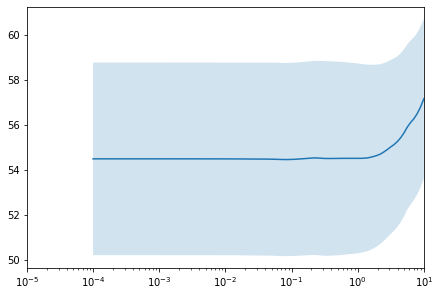

In [35]:
alpha = np.array(gs.cv_results_["param_lasso__alpha"], dtype="float64")
score = -gs.cv_results_["mean_test_score"]
score_std = gs.cv_results_["std_test_score"]
n_folds = gs.cv.get_n_splits()

plt.figure(layout="constrained")

ax = sns.lineplot(x=alpha, y=score)
ax.set_xscale("log")

plt.fill_between(
  x = alpha,
  y1 = score + 1.96*score_std / np.sqrt(n_folds),
  y2 = score - 1.96*score_std / np.sqrt(n_folds),
  alpha = 0.2
)

ax.set_xlim(1e-5, 10)
#ax.set_ylim(54.4, 54.6)

plt.show()

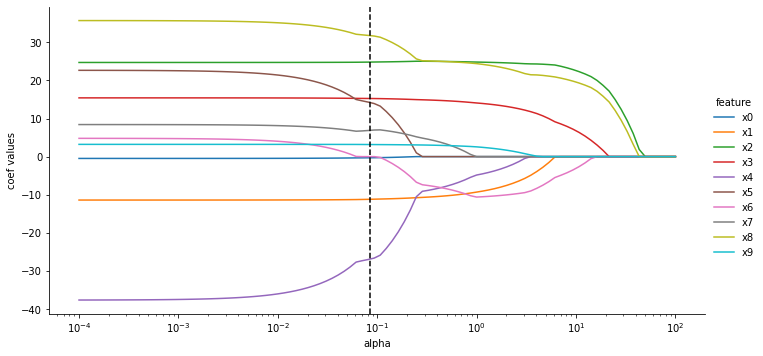

In [36]:
alpha = np.logspace(-4, 2, 100)
betas = []

for a in alpha:
    p = p.set_params(lasso__alpha = a)
    p = p.fit(X, y)
    
    betas.append(p.named_steps["lasso"].coef_)

res = pd.DataFrame(
  data = betas, columns = p[:-1].get_feature_names_out()
).assign(
  alpha = alpha  
)

res


g = sns.relplot(
  data = res.melt(id_vars="alpha", value_name="coef values", var_name="feature"),
  x = "alpha", y = "coef values", hue = "feature",
  kind = "line", aspect=2
)
g.set(xscale="log")
plt.axvline(x = gs.best_params_["lasso__alpha"], color="k", linestyle="--")
plt.show()